## Convolutional Baseline modeling

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import cv2 as cv

from matplotlib import pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import plot_model

In [2]:
tree_types = os.listdir('../data/image data/train')
X = []
y = []

for tree in tree_types:
    tree_path = os.path.join('../data/image data/train', tree)
    tree_disease_types = os.listdir(tree_path)

    for disease in tree_disease_types:
        img_name = os.listdir(os.path.join(tree_path, disease))

        for img in img_name:
            image_path = os.path.join(tree_path, disease, img)
            image = cv.resize(cv.imread(image_path), dsize=(128, 128))
            X.append(image)
            y.append([tree, disease])

In [3]:
val_x = []
val_y = []

for tree in tree_types:
    tree_path = os.path.join('../data/image data/validation', tree)
    tree_disease_types = os.listdir(tree_path)

    for disease in tree_disease_types:
        img_name = os.listdir(os.path.join(tree_path, disease))

        for img in img_name:
            image_path = os.path.join(tree_path, disease, img)
            image = cv.resize(cv.imread(image_path), dsize=(128, 128))
            val_x.append(image)
            val_y.append([tree, disease])

In [4]:
X = np.asarray(X)
val_x = np.asarray(val_x)

In [5]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)
val_y = mlb.transform(val_y)

In [6]:
train_generator = ImageDataGenerator(rescale=1. / 255)
val_generator = ImageDataGenerator(rescale=1. / 255)

train_gen = train_generator.flow(X, y, batch_size=32)
val_gen = val_generator.flow(val_x, val_y, batch_size=32)

In [7]:
base_conv = Sequential()

base_conv.add(InputLayer(input_shape=(128,128,3)))
base_conv.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',activation=relu))
base_conv.add(MaxPooling2D(pool_size=(2,2)))
base_conv.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation=relu))
base_conv.add(MaxPooling2D(pool_size=(2,2)))
base_conv.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation=relu))
base_conv.add(MaxPooling2D(pool_size=(2,2)))
base_conv.add(Flatten())
base_conv.add(Dense(units=128, activation=relu))
base_conv.add(Dense(units=64, activation=relu))
base_conv.add(Dense(units=42, activation=sigmoid))

base_conv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

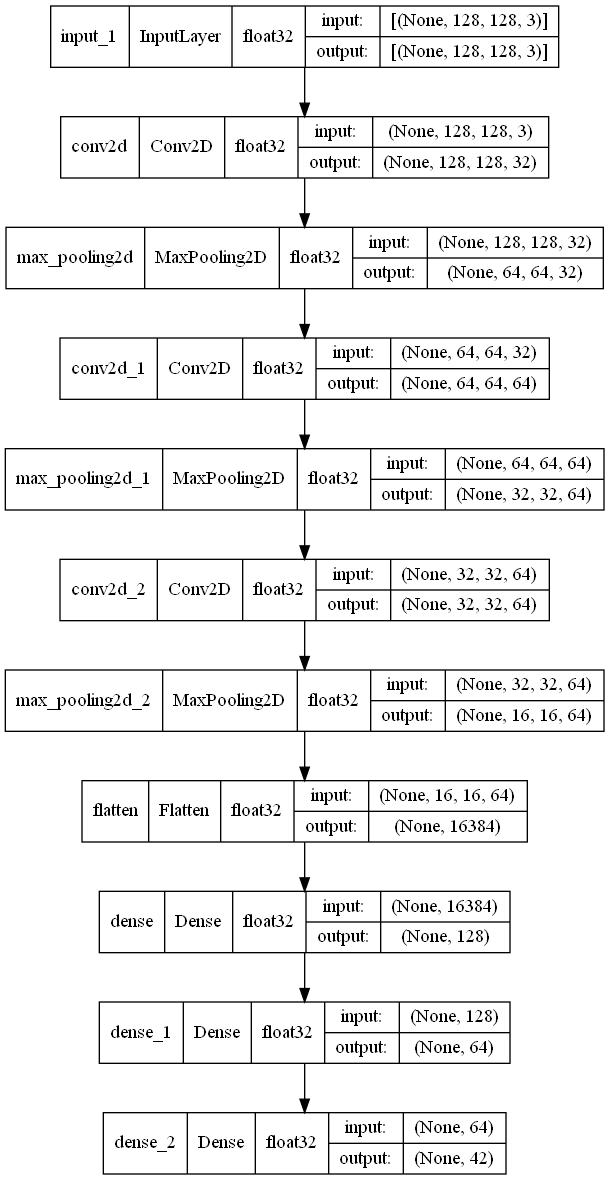

In [8]:
plot_model(base_conv,
           to_file='../models/baseline_conv.png',
           show_shapes=True,
           show_dtype=True,
           show_layer_names=True)

In [9]:
base_conv.compile(optimizer=Adam(),
                   loss=binary_crossentropy,
                   metrics=['accuracy'])

history = base_conv.fit(train_gen, batch_size=32, epochs=20, validation_data=val_gen)

Epoch 1/20
1218/1218 [==============================] - 125s 91ms/step - loss: 0.0846 - accuracy: 0.3225 - val_loss: 0.0481 - val_accuracy: 0.4445
Epoch 2/20
1218/1218 [==============================] - 98s 80ms/step - loss: 0.0387 - accuracy: 0.4205 - val_loss: 0.0364 - val_accuracy: 0.4742
Epoch 3/20
1218/1218 [==============================] - 90s 74ms/step - loss: 0.0272 - accuracy: 0.4368 - val_loss: 0.0294 - val_accuracy: 0.3833
Epoch 4/20
1218/1218 [==============================] - 90s 74ms/step - loss: 0.0205 - accuracy: 0.4456 - val_loss: 0.0228 - val_accuracy: 0.4284
Epoch 5/20
1218/1218 [==============================] - 90s 74ms/step - loss: 0.0167 - accuracy: 0.4430 - val_loss: 0.0239 - val_accuracy: 0.4336
Epoch 6/20
1218/1218 [==============================] - 89s 73ms/step - loss: 0.0136 - accuracy: 0.4402 - val_loss: 0.0224 - val_accuracy: 0.4771
Epoch 7/20
1218/1218 [==============================] - 89s 73ms/step - loss: 0.0114 - accuracy: 0.4362 - val_loss: 0.0259 

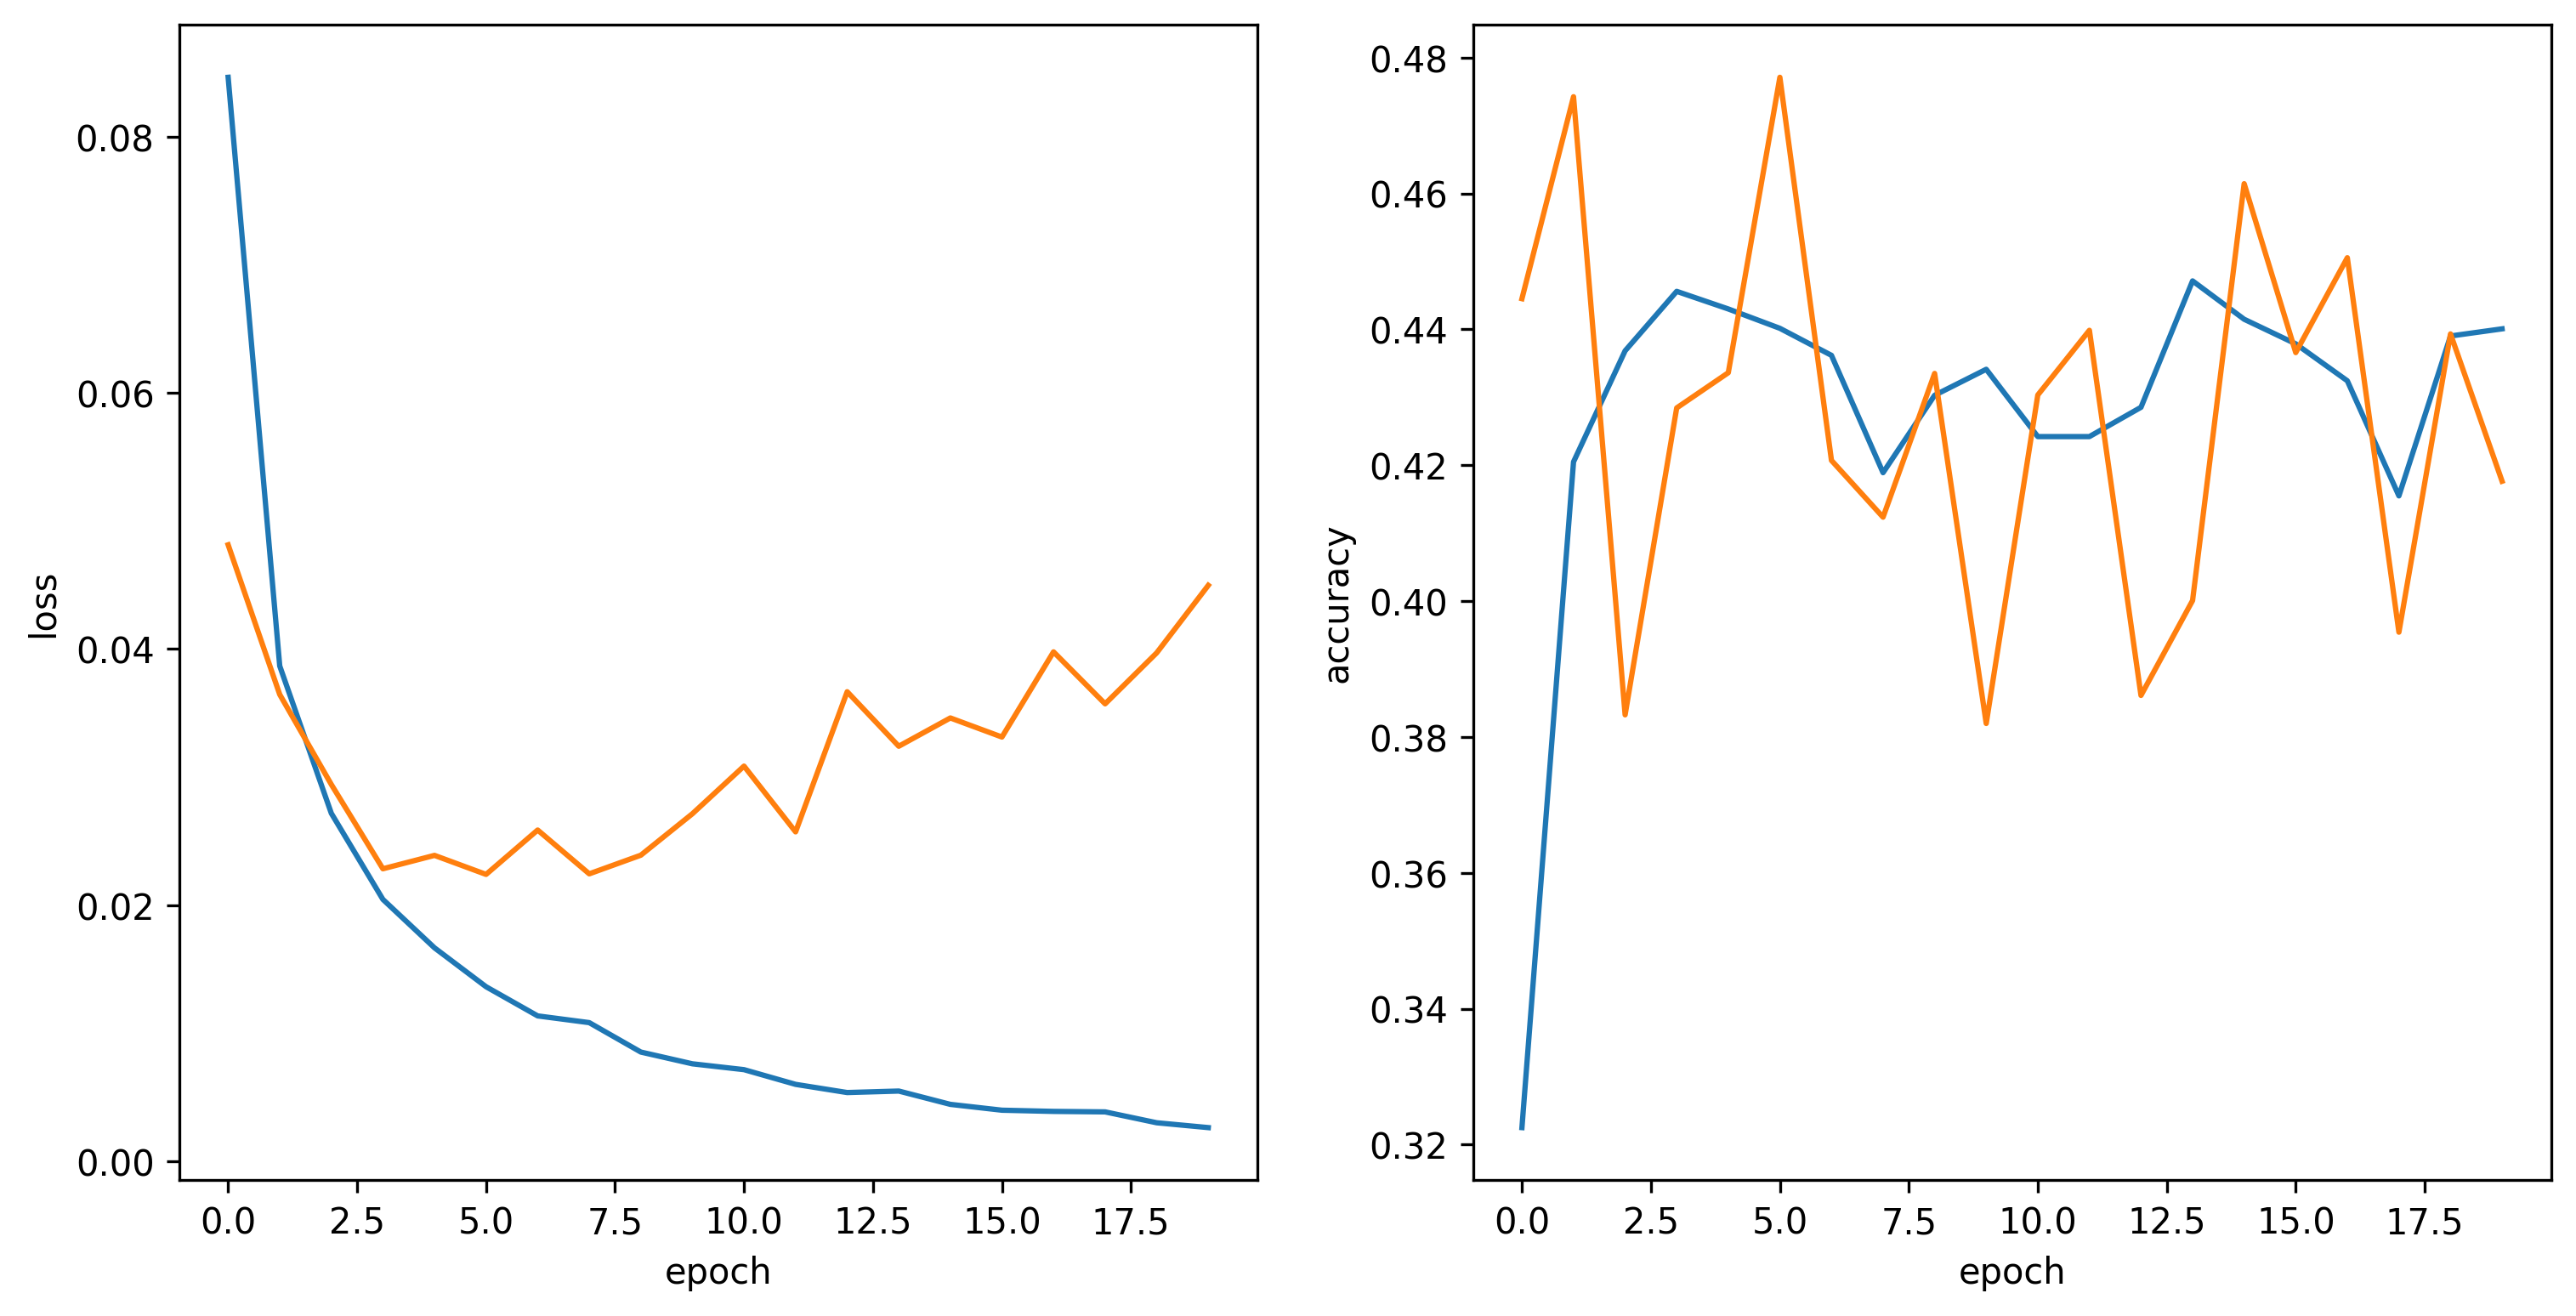

In [10]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 6], dpi=300)
axes = axes.ravel()
epochs = list(range(20))

sns.lineplot(x=epochs, y=history.history['loss'], ax=axes[0])
sns.lineplot(x=epochs, y=history.history['val_loss'], ax=axes[0])
sns.lineplot(x=epochs, y=history.history['accuracy'], ax=axes[1])
sns.lineplot(x=epochs, y=history.history['val_accuracy'], ax=axes[1])
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
plt.savefig('training log/baseline_conv_train_history.png')
plt.show()